In [1]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# deactivate grad
torch.set_grad_enabled(False)

# Utils

In [3]:
def print_current_results(epochs, Model, train_features, train_target, test_features, test_target, loss_sum, prefix = ""):
    print(prefix + "Epoch: {}, Train Error: {:.4f}%, Test Error: {:.4f}%, Loss  {:.4f}".format(epochs,
                                                                                      compute_accuracy(Model, train_features, train_target),
                                                                                      compute_accuracy(Model, test_features, test_target),
                                                                                      loss_sum))
def print_in_color(message, color = "red"):
    choices = {"green": "32", "blue": "34",
               "magenta": "35", "red": "31"}
    if message == "-h":
        return list(choices.keys())
    elif color == "":
        print(message)
    elif color in choices:
        print("\x1b[" + choices[color] + "m" + message + "\x1b[0m")
    else:
        raise ValueError("Available colors: {}, '-h' to get the list".format(choices.keys()))

# Data

Create a dataset of 1000 points with label 0 if outside the disk of radius 1/√2π and 1 inside

In [4]:
def generate_disc_set(nb):
    input = Tensor(nb, 2).uniform_(-1, 1)
    target = 1-input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    return input, target

In [5]:
def plot_dataset(features, target):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.title("Dataset")
    scatter = ax.scatter(features.numpy()[:, 0], features.numpy()[:, 1], c=target.numpy())
    legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="lower right")
    ax.add_artist(legend)
    return plt

In [6]:
def normalize_data(features):
    mean, std = features.mean(), features.std()
    return features.sub_(mean).div_(std)

<module 'matplotlib.pyplot' from 'C:\\Users\\antho\\Anaconda3\\envs\\venv_torch\\lib\\site-packages\\matplotlib\\pyplot.py'>

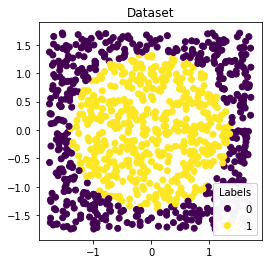

In [7]:
train_features, train_target = generate_disc_set(1000)
test_features, test_target = generate_disc_set(1000)

normalize_data(train_features)
normalize_data(test_features)
plot_dataset(train_features, train_target)

# Data management

In [90]:
def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

def compute_accuracy(model, data_features, data_target):
    predicted_classes = get_inferences(model, data_features)
    nb_data_errors = sum(data_target.data.numpy() != predicted_classes.numpy())
    return nb_data_errors/data_features.size(0)*100

def get_inferences(model, data_features):
    output = model.forward(data_features)
    _, predicted_classes = torch.max(output.data, 1)
    return predicted_classes

# Module Class

In [9]:
# heritage module definition
class Module(object):
    def __init__(self):
        super().__init__()
        self.lr = 0
    def forward(self, *input) :
        raise NotImplementedError
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []

In [10]:
possible_types = ["Linear", "Activation", "Loss"]

# activation functions

In [11]:
# Relu activation function
class ReLu(Module):
    def __init__(self ):
        super().__init__()
        self.type = "Activation"
        self.save = 0
    def forward(self, x):
        y = x.clamp(min=0)
        self.save = x
        return y
    def backward(self, x):
        y = self.save > 0
        return y.float()*x
    def print(self, color=""):
        print_in_color("\tReLU activation", color)
        return

# tanh activation function
class Tanh(Module):
    def __init__(self, ):
        super().__init__()
        self.type = "Activation"      
    def forward(self,x):
        y = (x.exp() - (-x).exp()) / ( x.exp() +  (-x).exp())
        return y
    def backward(self,x):
        y = 4*(x.exp() + x.mul(-1).exp()).pow(-2)
        return y
    def print(self):
        return

# MSE loss function

In [12]:
#MSE Loss implementation 
class LossMSE(Module):
    def __init__(self, ):
        super().__init__()
        self.type = "Loss"
    def loss(self,y,y_pred):
        loss = (y_pred - y).pow(2).sum()
        return loss
    def print(self, color=""):
        print_in_color("\tMSE", color)
    def grad(self,y,y_pred):
        return 2*(y_pred-y)

# Layers implementation

In [108]:
# Linear layer
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.type = "Linear"
        self.x = torch.zeros(out_features)        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.rand(size=(self.in_features,self.out_features))
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias = torch.rand(self.out_features)
        self.bias.data.uniform_(-stdv, stdv)

    def print(self, color = ""):
        msg = "\tLinear layer shape: {}".format([self.weight.size(0),self.weight.size(1)])
        print_in_color(msg, color)

    def print_weight(self):
        print(self.weight)

    def update(self, grad):
        lr = self.lr
        self.weight = self.weight - lr*self.x.t().mm(grad) 
        self.bias = self.bias - lr*grad.mean(0)*1

    def backward(self, grad):
        b = grad.mm(self.weight.t())
        self.update(grad)
        return b

    def forward(self, x):
        self.x = x
        # print("x, weight, bias", self.x.shape, self.weight.shape, self.bias.shape)
        return x.mm(self.weight) + self.bias

    def set_Lr(self, lr):
        self.lr = lr
        return

# Sequential architecture

In [99]:
# Sequential architecture
class Sequential(Module):
    def __init__(self, param, loss):
        super().__init__()
        self.type = "Sequential"
        self.model = param
        self.loss = loss

    def forward(self, x):
        for _object in self.model:
            x = _object.forward(x)
        return x
    
    def backward(self, y, y_pred):
        loss = self.loss.loss(y, y_pred)
        grad_pred = self.loss.grad(y, y_pred)
        for _object in reversed(self.model):
            grad_pred = _object.backward(grad_pred)
        return loss

    def print(self):
        print_color = True
        possible_colors = print_in_color("-h")
        if len(possible_colors) < len(possible_types):
            print('Not enough color available, {} more needed'.format(len(possible_types) - len(possible_colors)))
            print_color = False
        legend = ", ".join([possible_types[i] + " in " + possible_colors[i] for i in range(len(possible_types))])
        print("Model description: " + legend)
        for _object in self.model:
            if print_color:
                _object.print(possible_colors[possible_types.index(_object.type)])
            else:
                _object.print()
        if print_color:
            self.loss.print(possible_colors[possible_types.index(self.loss.type)])
        else:
            self.loss.print()

    def set_Lr(self, lr=0):
        for _object in self.model:
            if isinstance(_object, Linear):
                _object.set_Lr(lr)

# Training

In [133]:
nb_epochs = 100
batch_size = 30

# Build the model
Model = Sequential([Linear(2,128), ReLu(), Linear(128,2), ReLu()], LossMSE())
# Set the learning rate
Model.set_Lr(0.01)

# Print model's parameters
Model.print()

# Convert train_target to one hot encoding
train_target_one_hot = convert_to_one_hot_labels(train_features, train_target)

print_current_results(0, Model, train_features, train_target, test_features, test_target, 0, prefix = "Before training: ")

test_results = []
for epochs in range(0, nb_epochs):
    loss_sum = 0
    test_results.append(get_inferences(Model, test_features))
    for b in range(train_features.size(0) // batch_size):
        output = Model.forward(train_features.narrow(0, b * batch_size, batch_size))
        loss = Model.backward(train_target_one_hot.narrow(0, b * batch_size, batch_size), output)
        loss_sum = loss_sum + loss.item()
    if epochs % batch_size == 0:
        print_current_results(epochs + 1, Model, train_features, train_target, test_features, test_target, loss_sum)
        
print_current_results(epochs, Model, train_features, train_target, test_features, test_target, loss_sum, prefix = "After training: ")

Model description: Linear in green, Activation in blue, Loss in magenta
	Linear layer shape: [2, 128]
	ReLU activation
	Linear layer shape: [128, 2]
	ReLU activation
	MSE
Before training: Epoch: 0, Train Error: 49.2000%, Test Error: 50.0000%, Loss  0.0000
Epoch: 1, Train Error: 34.8000%, Test Error: 33.4000%, Loss  785.9048
Epoch: 31, Train Error: 5.1000%, Test Error: 7.4000%, Loss  149.8996
Epoch: 61, Train Error: 4.4000%, Test Error: 6.1000%, Loss  130.7002
Epoch: 91, Train Error: 4.0000%, Test Error: 6.4000%, Loss  118.8539
After training: Epoch: 99, Train Error: 3.7000%, Test Error: 6.3000%, Loss  116.1909


In [158]:
def plot_result_evolution(features, results_list, n):
    fig = plt.figure(figsize=(n*2, n*2))
    for i, result in enumerate(results_list[:n]):
        ax =fig.add_subplot(int(n//2), int(n//2), i+1)
        plt.title("Epoch n°{}".format(i))
        scatter = ax.scatter(features.numpy()[:, 0], features.numpy()[:, 1], c=result.numpy())
        legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="lower right")
        ax.add_artist(legend)

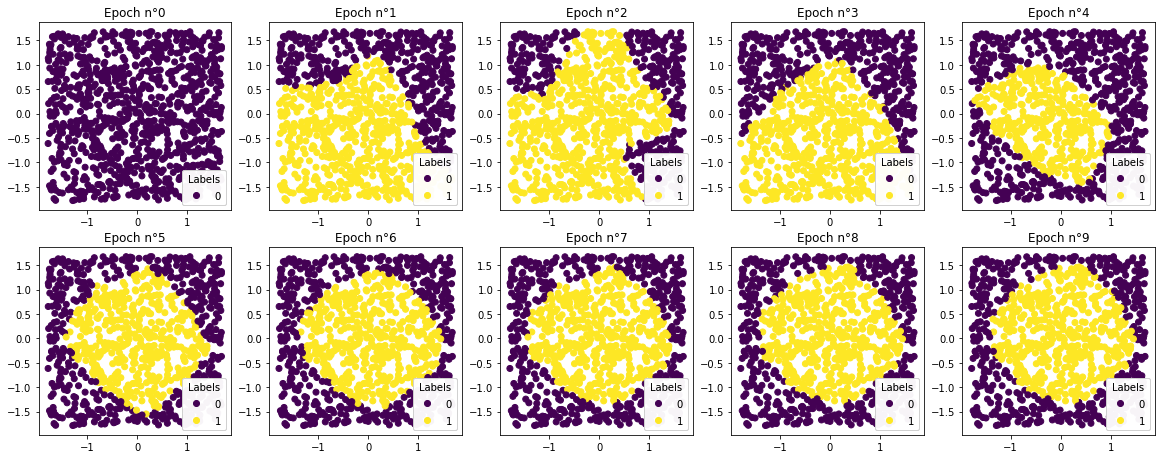

In [161]:
plot_result_evolution(test_features, test_results, 10)